In [102]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from embedders import Embedder
from database.milvusdb import MilvusDB
from query_expander import get_expander

from compute_difference_vector import get_sample_df
tqdm.pandas()
embedder = Embedder.create("Qwen/Qwen3-Embedding-0.6B", device="mps", normalize=True, for_queries=True)
samples = get_sample_df(2000, embedder)

Loaded 2000 examples
Using query expansion: QueryExpander(name=add_prev_3, data_length=2980)


100%|██████████| 2000/2000 [03:04<00:00, 10.84it/s]

Number of samples after denormalization: 2528


In [103]:
samples.head()

,source_doi,sent_original,sent_no_cit,sent_idx,target_doi,pubdate,resolved_bibcodes,sent_cit_masked,vector
0,10.1146/annurev-astro-082812-141031,"Indeed, Valenti et al. (2009) have argued that...","Jordan et al. (2012) , Kromer et al. (2013) , ...",595,10.1038/nature08023,20140801,[2009Natur.459..674V],"Indeed, [REF] have argued that SNe Iax are act...","[0.020763418, 0.014040946, -0.009526509, 0.012..."
1,10.1007/s00159-011-0047-3,Using a dedicated VLT/ISAAC multi-epoch SN sur...,"At even higher cluster redshift z ∼ 1, the Sup...",1029,10.1051/0004-6361/200911982,20111101,"[2009A&A...507...61S, 2009A&A...507...71G]",Using a dedicated VLT/ISAAC multi-epoch SN sur...,"[-0.005719765, -0.005792628, -0.012335606, 0.0..."
2,10.1007/s00159-011-0047-3,Using a dedicated VLT/ISAAC multi-epoch SN sur...,"At even higher cluster redshift z ∼ 1, the Sup...",1029,10.1051/0004-6361/200811254,20111101,"[2009A&A...507...61S, 2009A&A...507...71G]",Using a dedicated VLT/ISAAC multi-epoch SN sur...,"[-0.005719765, -0.005792628, -0.012335606, 0.0..."
3,10.1146/annurev-astro-081811-125615,"Madau et al. (1996 , 1998b ) and Lilly et al. ...",Redshifts z >4 have been confirmed from CO mea...,904,10.1093/mnras/283.4.1388,20140801,"[1996MNRAS.283.1388M, 1998ApJ...498..106M, 199...",[REF] and [REF] developed a different method w...,"[-0.02094898, -0.0007385412, -0.012135256, 0.0..."
4,10.1146/annurev-astro-081811-125615,"Madau et al. (1996 , 1998b ) and Lilly et al. ...",Redshifts z >4 have been confirmed from CO mea...,904,10.1086/305523,20140801,"[1996MNRAS.283.1388M, 1998ApJ...498..106M, 199...",[REF] and [REF] developed a different method w...,"[-0.02094898, -0.0007385412, -0.012135256, 0.0..."


In [104]:
db = MilvusDB()
def most_similar_to_query(example: pd.Series) -> np.ndarray:
    """
    Takes in an example (with 'vector' column already set), and from the candidates
    (returned entities with that doi from the database), returns the vector most similar
    to the example's vector.

    """
    # Converts 'vector' column to rows * dim array, holding the candidate vectors
    candidates = db.select_by_doi(example.target_doi, collection_name="qwen06_chunks")
    candidate_vectors = np.stack(candidates["vector"])
    best_idx = np.argmax(np.dot(candidate_vectors, example["vector"]))
    best_vector = candidate_vectors[best_idx]
    return best_vector

In [106]:
Q = np.array(samples['vector'].tolist()).T
print("Q shape:", Q.shape)

V = np.array([most_similar_to_query(row) for _, row in tqdm(samples.iterrows(), total=len(samples))]).T
print("V shape:", V.shape)

Q shape: (1024, 2528)


100%|██████████| 2528/2528 [00:20<00:00, 125.52it/s]


V shape: (1024, 2528)


In [107]:
M = V @ Q.T
U, S, Vt = np.linalg.svd(M)
R = U @ Vt

print("det R:", np.linalg.det(R))
# if np.linalg.det(R) < 0:
#     D = np.eye(R.shape[0])
#     D[-1, -1] = -1
#     R = U @ D @ Vt
# print("corrected det R:", np.linalg.det(R))

det R: 0.9999999999998714


In [108]:
research_dois = set(samples.target_doi)
print(research_dois)

{'10.1088/0004-637X/690/1/252', '10.1086/310536', '10.1088/0004-637X/758/1/29', '10.1086/190641', '10.1086/146592', '10.1088/0004-637X/796/2/106', '10.1086/374266', '10.1126/science.1185759', '10.3847/1538-4357/aaa8e4', '10.1051/0004-6361/201015136', '10.1093/mnras/189.1.95', '10.1111/j.1365-2966.2005.09043.x', '10.1086/339033', '10.1086/509252', '10.1086/339025', '10.1093/mnras/sty1609', '10.1086/171488', '10.1093/mnrasl/slt005', '10.1126/science.1112997', '10.1086/176560', '10.1086/320281', '10.1086/163867', '10.1086/164050', '10.1089/15311070260192246', '10.1093/mnras/283.2.L45', '10.1086/323301', '10.1051/0004-6361:20064812', '10.1046/j.1365-8711.1999.02978.x', '10.1142/S0218271807010511', '10.1086/173608', '10.1086/510377', '10.3847/0004-637X/821/2/116', '10.1016/j.pepi.2017.05.010', '10.1093/mnras/stab1347', '10.1023/A:1014257826116', '10.1086/500084', '10.1086/177538', '10.1093/mnras/157.1.1', '10.1111/j.1365-2966.2005.08890.x', '10.1086/185876', '10.1111/j.1365-2966.2006.11353.

In [109]:
import random

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def negative_vectors(example: pd.Series, n=5):
    # Get all target DOIs for this example, sample from those not cited
    rows = samples[(samples.source_doi == example.source_doi) & (samples.sent_idx == example.sent_idx)]
    citation_dois = set(rows.target_doi)
    neg_dois = list(research_dois - citation_dois)
    neg_samples = random.sample(neg_dois, n)
    
    # Get vectors for negative samples
    neg_vectors = np.zeros((n, embedder.dim))
    for i, doi in enumerate(neg_samples):
        records = db.select_by_doi(doi, collection_name="qwen06_chunks")
        sample_record = records.sample(n=1).iloc[0]
        neg_vectors[i] = np.array(sample_record['vector'])
    return neg_vectors


res = negative_vectors(samples.iloc[998])
print(res)

[[ 0.01416037 -0.02472416 -0.00868168 ... -0.03756281  0.00321639
   0.02629269]
 [-0.00253146 -0.03019513 -0.0113809  ... -0.05053932  0.00454899
   0.00148387]
 [ 0.06732493  0.01227504 -0.00782838 ...  0.0021212  -0.02832617
  -0.06360837]
 [ 0.09135149 -0.05921357 -0.01045837 ... -0.00018661  0.01827949
  -0.04544412]
 [-0.03404198  0.0088949  -0.00757207 ... -0.08317601  0.032639
  -0.01415783]]


Citation DOIs: {'10.1046/j.1365-8711.2000.03810.x', '10.1086/316394', '10.1086/186883'}

In [110]:
df = db.select_by_doi("10.1046/j.1365-8711.2000.03810.x", collection_name="qwen06_chunks")
row = df.sample(n=1).iloc[0]
print(np.array(row['vector']))

[-0.03956052 -0.01184224 -0.00785502 ... -0.06036706 -0.00767789
 -0.01078254]


In [111]:
differences_to_target = []
differences_to_negative = []
for _, row in samples.iterrows():
    query_vector = row['vector']
    target_vector = most_similar_to_query(row)
    aligned_query_vector = R @ query_vector
    before = cosine_similarity(query_vector, target_vector)
    after = cosine_similarity(aligned_query_vector, target_vector)

    differences_to_target.append(after - before)
    neg_vectors = negative_vectors(row, n=5)
    batch_distance_to_negative = []
    for neg_vector in neg_vectors:
        before_neg = cosine_similarity(query_vector, neg_vector)
        after_neg = cosine_similarity(aligned_query_vector, neg_vector)
        batch_distance_to_negative.append(after_neg - before_neg)
        differences_to_negative.append(after_neg - before_neg)
    print(_)
    print(f"Improvement to target: {after - before:.4f}")
    print(f"Distance to negatives: {np.mean(batch_distance_to_negative):.4f} ± {np.std(batch_distance_to_negative):.4f}")
    print("---")
print(f"Average improvement (target): {np.mean(differences_to_target):.6f} ± {np.std(differences_to_target):.6f}")
print(f"Average improvement (negative): {np.mean(differences_to_negative):.6f} ± {np.std(differences_to_negative):.6f}")

0
Improvement to target: 0.1491
Distance to negatives: 0.0210 ± 0.0078
---
1
Improvement to target: 0.0329
Distance to negatives: 0.0066 ± 0.0083
---
2
Improvement to target: 0.0421
Distance to negatives: -0.0022 ± 0.0183
---
3
Improvement to target: 0.0619
Distance to negatives: 0.0078 ± 0.0127
---
4
Improvement to target: 0.1011
Distance to negatives: 0.0135 ± 0.0141
---
5
Improvement to target: 0.1053
Distance to negatives: 0.0054 ± 0.0165
---
6
Improvement to target: 0.1128
Distance to negatives: 0.0019 ± 0.0103
---
7
Improvement to target: 0.0823
Distance to negatives: -0.0018 ± 0.0103
---
8
Improvement to target: 0.0393
Distance to negatives: 0.0088 ± 0.0131
---
9
Improvement to target: 0.0832
Distance to negatives: -0.0055 ± 0.0168
---
10
Improvement to target: 0.1298
Distance to negatives: 0.0067 ± 0.0170
---
11
Improvement to target: 0.0623
Distance to negatives: 0.0134 ± 0.0201
---
12
Improvement to target: 0.1420
Distance to negatives: 0.0095 ± 0.0101
---
13
Improvement to t

In [91]:
print(R.shape)

(1024, 1024)


In [116]:

U, S, Vt = np.linalg.svd(M, full_matrices=False)
print("rank approx:", np.sum(S > 1e-8))
print("singular values (top/last):", S[:30], S[-5:])

rank approx: 1024
singular values (top/last): [792.72157165  61.88210342  49.26255328  42.11091317  37.09051906
  33.66562641  27.52383042  24.30065262  19.50426182  16.79601866
  15.51746048  15.01488033  14.70857626  13.21117946  12.33618357
  12.01556453  11.21467511  10.8837886   10.13666037   9.87542691
   9.56121457   9.23783727   8.92240271   8.66061226   8.39474348
   8.25087163   7.76567553   7.68362493   7.41713957   7.07309159] [1.89974940e-04 1.44534921e-04 1.19801223e-04 5.41603874e-05
 1.83628887e-05]


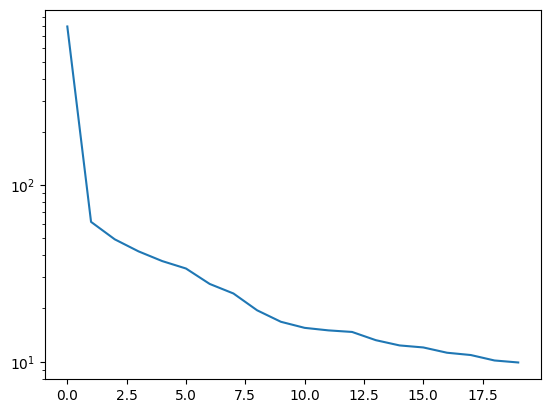

In [122]:
import matplotlib.pyplot as plt
U, S, Vt = np.linalg.svd(M)
plt.semilogy(S[:20])  # plot singular values

In [114]:
np.save('qwen06_chunks_rotation_n2000.npy', R)

In [123]:
sigma1 = S[0]
eps = 1e-6  # try 1e-6 .. 1e-8 as needed
r = 2
# r = np.searchsorted(S / sigma1 < eps, True)  # first index where ratio < eps
print(f"Chosen rank r: {r}")
if r == 0:
    r = len(S)  # fallback if no small ones found
# alternative: r = np.searchsorted(np.cumsum(S**2) / np.sum(S**2), 0.99) + 1

# build small rotation in top-r
Ur = U[:, :r]  # n x r
Vr = Vt[:r, :].T  # n x r  (since Vt[:r,:] is r x n)
Msmall = Ur.T @ M @ Vr  # should be r x r but simpler compute: Tproj.T @ Qproj if you had them
# simpler: compute r x r cross-covariance directly via projections:
# Qproj = Q_all @ Ur  # expensive if many, but doable; here we reuse M decomposition
# but we can use SVD of the small Mslice: compute Us, Ss, Vts = svd(Ur.T @ M @ Vr)

# directly SVD the r x r matrix (numerically stable):
Us, Ss, Vts = np.linalg.svd(Ur.T @ M @ Vr, full_matrices=False)
Rsmall = Us @ Vts
# ensure proper rotation (det +1)
if np.linalg.det(Rsmall) < 0:
    D = np.eye(r)
    D[-1, -1] = -1
    Rsmall = Us @ D @ Vts

# map basis Ur to rotated basis Ur @ Rsmall @ Ur.T, then add identity on complement
R_full = Ur @ Rsmall @ Ur.T + (np.eye(1024) - Ur @ Ur.T)
print("det R_full:", np.linalg.det(R_full))
print(R_full.shape)

Chosen rank r: 2
det R_full: 0.9999999999999999
(1024, 1024)


In [124]:
np.save('qwen06_chunks_r2.npy', R_full)